In [1]:
import numpy as np
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F
from itertools import combinations, product
import pickle
from enviroments import env_p2p

In [2]:
#Fares disponibles
f = [500,400,300,200,100]
m = len(f) 

#Probabilidad de llegada de un comprador (arraibal probablity)
lambd = 0.3

# Parametro que modela la disponibilidad a pagar (Willnes to pay)
beta= 0.5

#Capacidad de la aeronave
C = 50

#Horizonte temporal máximo
T = 50

seats = np.arange(0, C + 1)
time = np.arange(0, T)

env = env_p2p(lambd, beta, C, T, f, model = "DQL")

In [3]:
# Cargar la matriz desde el archivo pickle
with open('results/V_value.pickle', 'rb') as archivo:
    V_value = pickle.load(archivo)

# Cargar el vector desde el archivo pickle
with open('results/Q_value.pickle', 'rb') as archivo:
    Q_value = pickle.load(archivo)

In [4]:
nS = 2
nA = len(env.action_space)
nH = 128

In [5]:
gamma = 1
alpha = 1e-5
eps = 1.0
n = 1
eps_decay = 0.9999**(1/n)
batch_size = 200

In [6]:
max_episodes = 70000*n
max_steps = 100

In [7]:
qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

In [8]:
#qnet.load_state_dict(torch.load('results/qnet.pth'))

In [9]:
opt = torch.optim.Adam(qnet.parameters(), lr=alpha)

In [10]:
@dataclass
class Transition:
    state: int
    action: int
    next_state: int
    reward: float
    done: bool

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, *args):
        data = Transition(*args)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample_batch(self, batch_size):
        return [self._storage[random.randint(0, len(self._storage) - 1)] for _ in range(batch_size)]

In [11]:
def select_action(net, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    with torch.no_grad():
        return net(torch.tensor(np.array(s),dtype=torch.double)).argmax().item()


In [12]:
def train(qnet, buffer, opt):
    sample = buffer.sample_batch(batch_size)
    s = torch.tensor(np.array([t.state for t in sample]), dtype=torch.double)
    s_prime = torch.tensor(np.array([t.next_state for t in sample]), dtype=torch.double)
    a = torch.tensor([t.action for t in sample])
    r = torch.tensor([t.reward for t in sample])
    d = 1 - 1*torch.tensor([t.done for t in sample])

    q = qnet(s)[np.arange(a.shape[0]), a]
    q_expected = r + gamma * d * qnet(s_prime).max(dim=1).values
    criterion = torch.nn.MSELoss()

    loss = criterion(q, q_expected)
    
    opt.zero_grad()
    loss.backward()
    opt.step()

In [15]:
Rs = []
Eps = []
buffer = ReplayBuffer(10_000)
N = np.zeros((C+1,T))
for episode in range(max_episodes):
    s, _ = env.reset()
    R = 0
    for step in range(max_steps):
        a = select_action(qnet, s, eps)
        s_prime, r, done, _, _ = env.step(a)
        N[s[0],s[1]] += 1
        buffer.push(s, a, s_prime, r, done)
        R += r
        
        train(qnet, buffer, opt)

        if done:
            break
            
        s = s_prime
        eps *= eps_decay
    Rs.append(R)
    Eps.append(eps)
    print(f'{episode}/{max_episodes}: {Rs[-1]} \r', end='')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
100
0
0
0
0
0
0
0
0
0
0
500
0/70000: 600 
200
0/70000: 200 
0
0
0
0
0
0
0
300
0
500
0
0
0
0
0
0
100
0
0
0
0
0
0
0/70000: 900 
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0/70000: 0 
0
0
0
0
0
100
0
0
0
0
0
0
0
0
0
0
0
0
0
0
300
0
0
500
0
0
500
0
0
0
0
0
0
0
400
3000000: 1800 
0
0
0
0
0
0
0
0
0
300
100
0
400
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0/70000: 1100 
0
0
0
0/70000: 0 
0
0
0
0
0
100
0
0
0
0
0
0
100
0
0
0
0
0
0
0
0
0
0
100
0/70000: 300 
0
0/70000: 0 
0
0
0
0
500
100
0
0
0
0
0
200
0
0
0
0
0
0
0
0
0
0
0
0
0
0
400
0
0
0
0
0
0
0
0
0
0
0
3000000: 1200 
00/70000: 300 
0
0
0
100
200
0
0
0
0
0
0
0
0
0
100
100
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
200
0
0
01/70000: 700 
0
300
0
0
0
0
0
0
500
0
0
0
0
300
100
0
0
0
0
0
0
0
100
0
0
0
0
0
0
0
02/70000: 1300 
0
0
0
0
0
0
0
0
300
0
0
0
0
0
100
0
0
0
200
0
100
500
0
100
03/70000: 1300 
0
0
0
0
0
04/70000: 0 
200
0
300
0
0
0
0
0
0
0
500
0
0
0
0
0
0
0
0
100
100
0
0
0
0
200
0
0
0
0
0
0
0
0
05/70000: 1400 
0
0
0
0
0
0
0
0
0
10

KeyboardInterrupt: 

In [ ]:
#torch.save(qnet.state_dict(), 'results/qnet.pth')

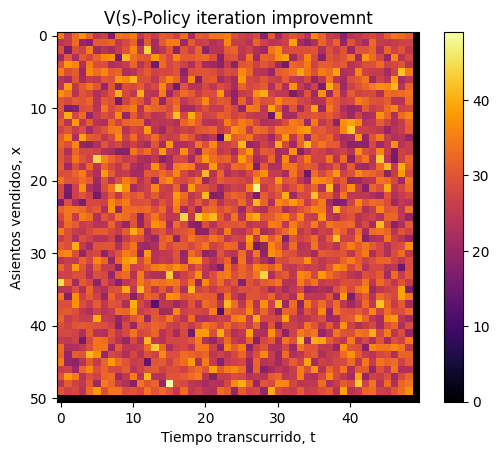

In [ ]:

plt.imshow(N, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)-Policy iteration improvemnt')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

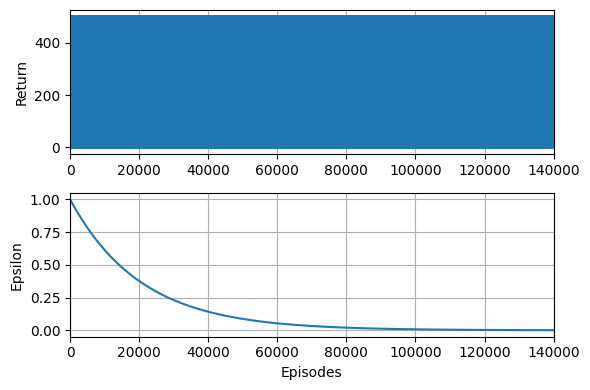

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Rs)
axes[0].set_xlim(0, max_episodes)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, max_episodes)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon")
plt.tight_layout()
plt.show()

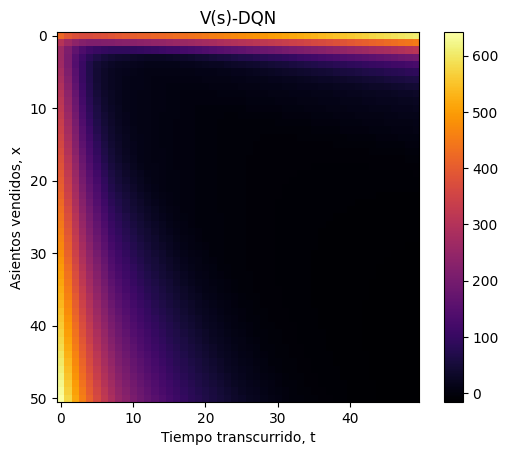

In [91]:
seats = np.arange(0, C + 1)
time = np.arange(0, T)
matriz = np.zeros((C+1,T))
V_dqn = np.zeros((C+1)*T)
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    s = torch.tensor([x,t], dtype=torch.double)
    matriz[x,t] = torch.max(qnet(s))
    V_dqn[idx] = matriz[x,t]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)-DQN')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()


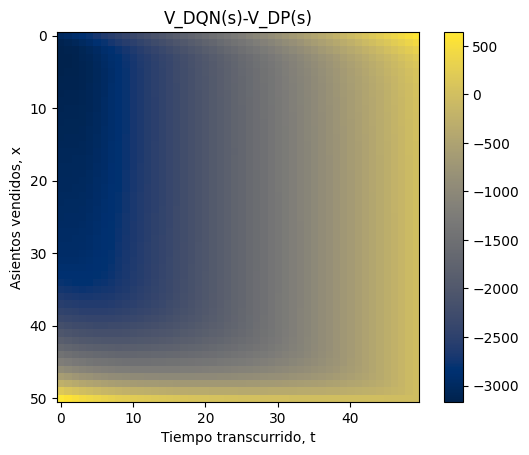

In [92]:
seats = np.arange(0, C + 1)
time = np.arange(0, T)
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_dqn[idx] - np.max(Q_value[idx,:])

plt.imshow(matriz, cmap='cividis', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V_DQN(s)-V_DP(s)')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()
